# Ma formation : Opencv 

## import package

In [1]:
from asyncio import threads
from pickletools import uint8
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

## Functions

In [2]:
def getPerspective(img,location,height = 900, width = 900):
    cornersOg = np.float32([location[0], location[3], location[1], location[2]])
    cornersFlattened = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
    transformMatrix = cv2.getPerspectiveTransform(cornersOg,cornersFlattened)
    result = cv2.warpPerspective(img,transformMatrix,(width,height))
    return result

In [4]:
#Create the webcam object using the default cam (0)
cam = cv2.VideoCapture(0)
if not cam.isOpened():
    raise IOError("Error opening cam")

while True:
    #Fetch the image of the cam
    [ret,image] = cam.read()
    if not ret:
        raise IOError("No image fetched")
    #Convert it to grayScale
    grayImage = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    #Tresholding
    t1 = cv2.adaptiveThreshold(grayImage,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,9,4)

    #Contouring
    contours, Hierarchy = cv2.findContours(t1,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for i,contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area>16000:
            approx = cv2.approxPolyDP(contour,0.01*cv2.arcLength(contour,True),True)
            if len(approx == 4):
                mask = np.zeros(image.shape,np.uint8)
                cv2.drawContours(image,contours,i,(255,255,0),2)

    #Showing images
    cv2.imshow("Og", image)
    cv2.imshow("grayScale", grayImage)
    cv2.imshow("treshold", t1)

    c = cv2.waitKey(1)
    #Leave the loop whe "Esc" is pressed
    if c == 27:
        print("Esc pressed")
        break

cam.release()
cv2.destroyAllWindows()

Esc pressed


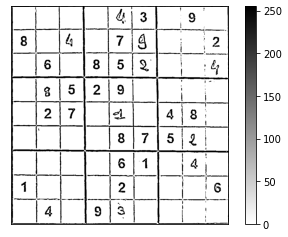

In [9]:
#Flatten the grid
flatImage = getPerspective(grayImage,approx)
flatImageBlur = cv2.GaussianBlur(flatImage,(5,5),1)
flatImageTresh = cv2.adaptiveThreshold(flatImageBlur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,9,3)
plt.imshow(flatImageTresh,cmap='binary')
plt.xticks([])
plt.yticks([])
plt.colorbar()


In [17]:
#Go through the sudoku grid
sudoku = np.zeros((9,9),np.int8)
allInput = []

for idx,x in np.ndenumerate(sudoku):
    i = idx[0]
    j = idx[1]
    cellImage = flatImageTresh[i*100+5:i*100+90,j*100+5:j*100+90]
    cellImageBlurred = cv2.GaussianBlur(cellImage,(3,3),2)
    cellImageInput = cv2.resize(cellImageBlurred,(28,28))
    input = np.asarray(cellImageInput,dtype=np.float32)
    inputNormalized = input/255.0
    allInput.append(inputNormalized)

## Load the model

In [18]:
#Load the MNIST model
MNIST_model = tf.keras.models.load_model('saved_model/MNIST')

In [19]:
arg = tf.convert_to_tensor(allInput)
probability_model = tf.keras.Sequential([MNIST_model,tf.keras.layers.Softmax()])
predictions = probability_model.predict(arg)


3/3 [==============================] - 0s 1ms/step


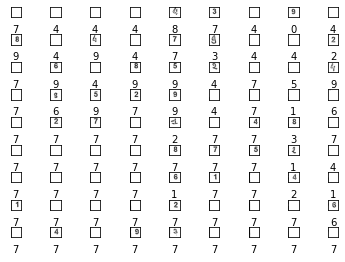

In [20]:
for i in range(len(predictions)):
    res = np.argmax(predictions[i])
    #print(i," : ",res)
    plt.subplot(9,9,i+1)
    plt.imshow(allInput[i],cmap=plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(res)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=1.7)
plt.show()